# Naive Approach: Time Series Forecasting on Bank Transaction Data

**Goal:** Forecast daily `withdrawal_amt` and `deposit_amt` using beginner-level time series techniques.

**Read `naive_approach.txt` alongside this notebook for detailed explanations of each step.**

---
## Part A: Data Loading, Cleaning & Aggregation
*(Pre-existing code — gets us to the aggregated daily data)*

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('bank_clean.csv')

In [3]:
df.info()
53549 + 62652

<class 'pandas.DataFrame'>
RangeIndex: 116201 entries, 0 to 116200
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   account_no           116201 non-null  int64  
 1   date                 116201 non-null  str    
 2   transaction_details  113702 non-null  str    
 3   cheque_no            905 non-null     float64
 4   value_date           116201 non-null  str    
 5   withdrawal_amt       53549 non-null   float64
 6   deposit_amt          62652 non-null   float64
 7   balance_amt          116201 non-null  float64
dtypes: float64(4), int64(1), str(3)
memory usage: 7.1 MB


116201

In [4]:
df.sample(5)

,account_no,date,transaction_details,cheque_no,value_date,withdrawal_amt,deposit_amt,balance_amt
31213,1196711,2015-12-03,INTERNAL FUND TRANSFER IN,NaN,2015-12-03,15000000.0,NaN,-1.559180e+09
57774,1196428,2016-12-08,CASHDEP/GURGAON/SBN,NaN,2016-12-08,NaN,2746000.00,-1.645063e+09
26240,409000438620,2018-12-31,AEPS GST INC DT 12-30-201,NaN,2018-12-31,NaN,229.05,-5.283021e+08
87977,409000362497,2015-09-18,INDIAIDEAS.COM LTD,NaN,2015-09-18,326719.0,NaN,-1.650914e+09
49784,1196428,2016-05-06,CASHDEP/GURGAON/,NaN,2016-05-06,NaN,416000.00,-1.614939e+09


In [5]:
df.shape

(116201, 8)

In [6]:
df.duplicated().sum()

np.int64(39)

In [7]:
df.head()

,account_no,date,transaction_details,cheque_no,value_date,withdrawal_amt,deposit_amt,balance_amt
0,409000611074,2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0
1,409000611074,2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0
2,409000611074,2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0
3,409000611074,2017-08-01,TRF FRM Indiaforensic SERVICES,NaN,2017-08-01,NaN,3000000.0,5500000.0
4,409000611074,2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,6000000.0


In [8]:
df = df.drop(
    ["account_no", "transaction_details", "cheque_no", "date", "balance_amt"],
    axis=1
)

In [9]:
df.head()

,value_date,withdrawal_amt,deposit_amt
0,2017-06-29,NaN,1000000.0
1,2017-07-05,NaN,1000000.0
2,2017-07-18,NaN,500000.0
3,2017-08-01,NaN,3000000.0
4,2017-08-16,NaN,500000.0


In [10]:
df["value_date"] = pd.to_datetime(df["value_date"])

df = (
    df
    .groupby("value_date", as_index=False)
    .agg({
        "withdrawal_amt": "sum",
        "deposit_amt": "sum"
    })
)

In [11]:
df.head()

,value_date,withdrawal_amt,deposit_amt
0,2015-01-01,0.00,2004999.0
1,2015-01-02,5500056.18,2465620.0
2,2015-01-03,2200000.00,2948160.0
3,2015-01-05,3231000.00,3909020.0
4,2015-01-06,3880056.18,3650750.0


---
## Part B: Time Series Preparation & EDA
*(New code starts here — building on the aggregated data above)*

### Step 1: Set Date as Index

**Why?** Right now `value_date` is just a regular column. Time series tools in Python
need the date to be the **index** (row label) so they know this data is ordered by time.
Without this, `.rolling()`, `.resample()`, `.shift()` won't work correctly.

In [12]:
df.set_index('value_date', inplace=True)
df.index.name = 'date'

print(f'Date range: {df.index.min()} to {df.index.max()}')
print(f'Total rows: {len(df)}')
df.head()

Date range: 2015-01-01 00:00:00 to 2019-03-05 00:00:00
Total rows: 1294


,withdrawal_amt,deposit_amt
date,,
2015-01-01,0.00,2004999.0
2015-01-02,5500056.18,2465620.0
2015-01-03,2200000.00,2948160.0
2015-01-05,3231000.00,3909020.0
2015-01-06,3880056.18,3650750.0


### Step 2: Handle Missing Dates

**Why?** Notice Jan 3 → Jan 5 (Jan 4 is missing). Time series models need a
CONTINUOUS calendar — no gaps. If we skip a day, the model thinks Jan 5 comes
right after Jan 3, which is wrong.

**How?** Create every date from start to end, reindex, fill missing days with 0
(no transactions = zero amount).

In [13]:
# Create complete date range with every single day
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

missing = full_range.difference(df.index)
print(f'Missing dates: {len(missing)} days had no transactions')

# Reindex: missing days become NaN, then fill with 0
df = df.reindex(full_range)
df.index.name = 'date'
df = df.fillna(0)

print(f'After filling: {len(df)} continuous days')
df.head(10)

Missing dates: 231 days had no transactions
After filling: 1525 continuous days


,withdrawal_amt,deposit_amt
date,,
2015-01-01,0.00,2004999.0
2015-01-02,5500056.18,2465620.0
2015-01-03,2200000.00,2948160.0
2015-01-04,0.00,0.0
2015-01-05,3231000.00,3909020.0
2015-01-06,3880056.18,3650750.0
2015-01-07,3650000.00,3455070.0
2015-01-08,3450000.00,4550200.0
2015-01-09,4550000.00,4902100.0


### Step 3: Visualize the Time Series

**Why?** Before any test, LOOK at the data. Your eyes can spot trends, seasonality,
and outliers instantly. We're looking for:
- Is the line going up/down over time? → **Trend**
- Are there repeating wave patterns? → **Seasonality**
- Are there sudden extreme spikes? → **Outliers**

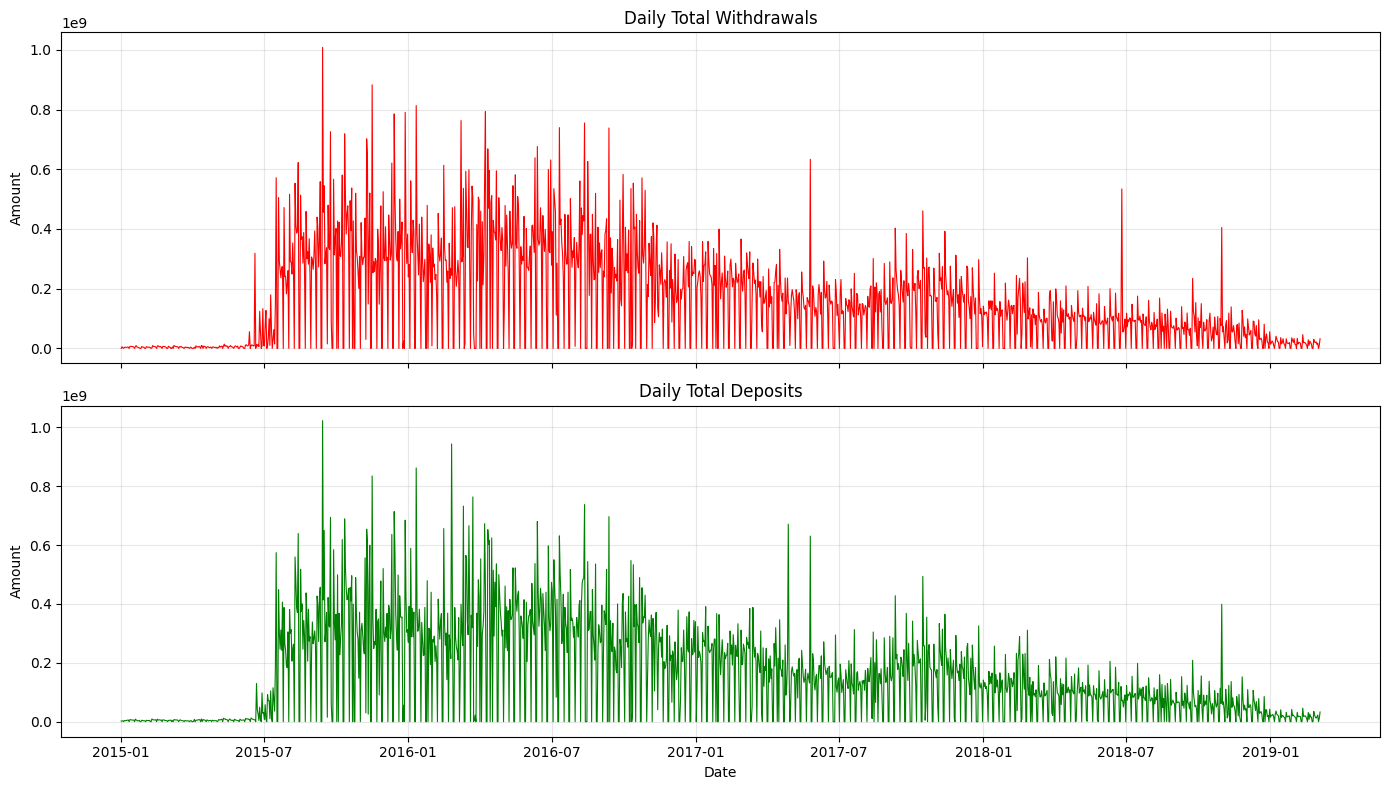

In [14]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(df['withdrawal_amt'], color='red', linewidth=0.8)
axes[0].set_title('Daily Total Withdrawals')
axes[0].set_ylabel('Amount')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['deposit_amt'], color='green', linewidth=0.8)
axes[1].set_title('Daily Total Deposits')
axes[1].set_ylabel('Amount')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 4: Time Series Decomposition

**Why?** Every time series = Trend + Seasonality + Residual (noise).
Decomposition SEPARATES these so we can see each one individually.

- If **trend** exists → we need differencing later
- If **seasonality** is strong → SARIMA will outperform ARIMA
- If **residuals** are small → our model can capture most of the signal

We use `period=7` because we expect weekly patterns (7 days in a week).

*(See naive_approach.txt → Step 4 for additive vs multiplicative explanation)*

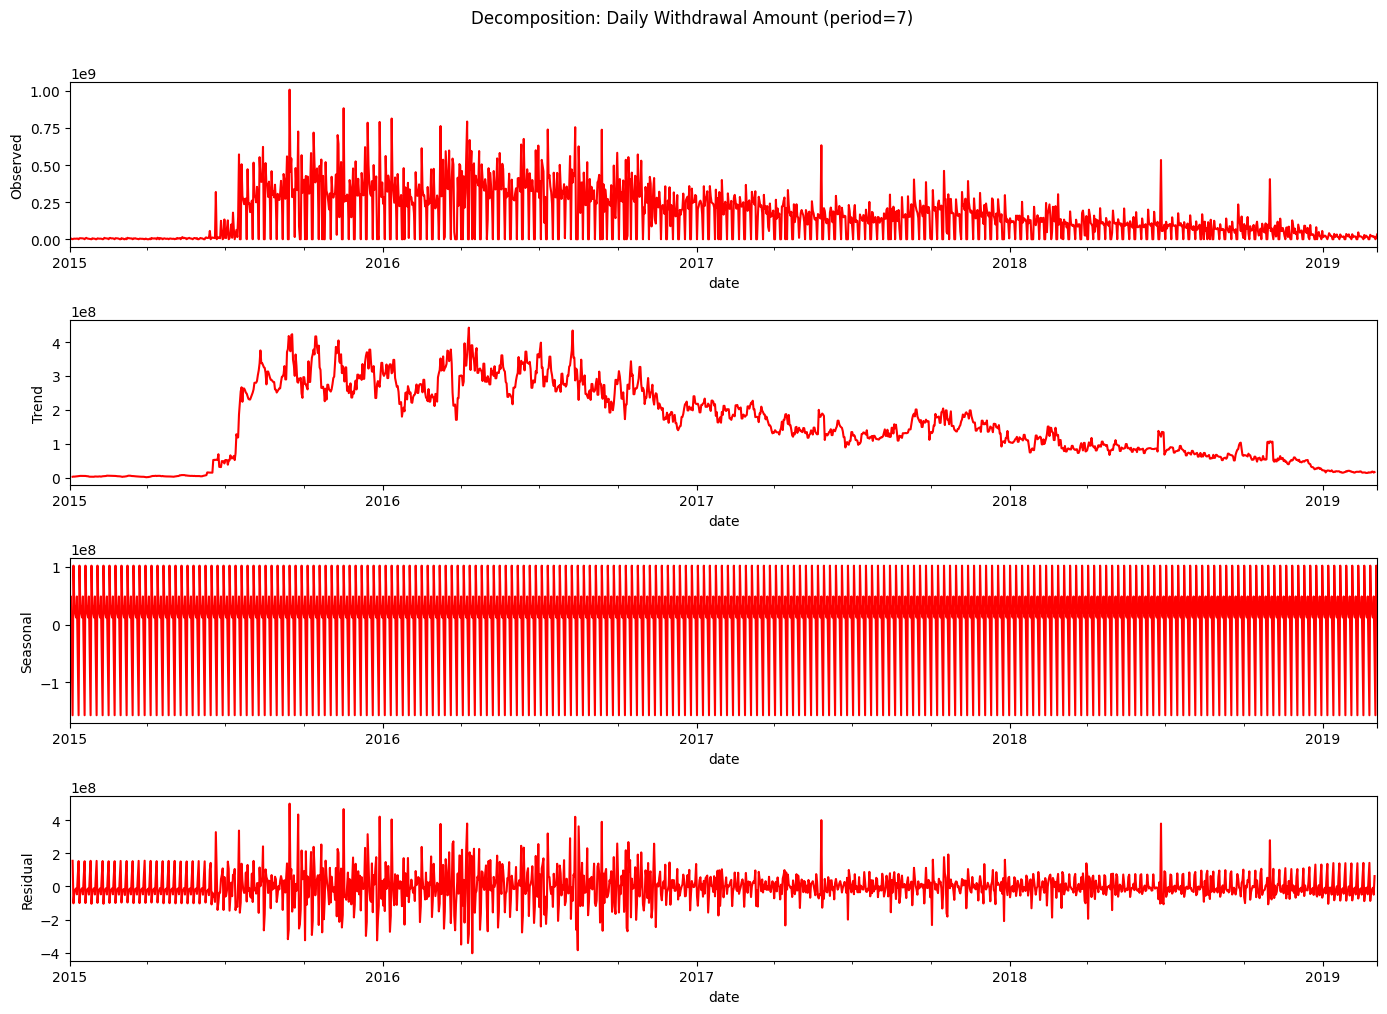

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose WITHDRAWAL amount
decomp_w = seasonal_decompose(df['withdrawal_amt'], model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
decomp_w.observed.plot(ax=axes[0], color='red')
axes[0].set_ylabel('Observed')
decomp_w.trend.plot(ax=axes[1], color='red')
axes[1].set_ylabel('Trend')
decomp_w.seasonal.plot(ax=axes[2], color='red')
axes[2].set_ylabel('Seasonal')
decomp_w.resid.plot(ax=axes[3], color='red')
axes[3].set_ylabel('Residual')

fig.suptitle('Decomposition: Daily Withdrawal Amount (period=7)', y=1.01)
plt.tight_layout()
plt.show()

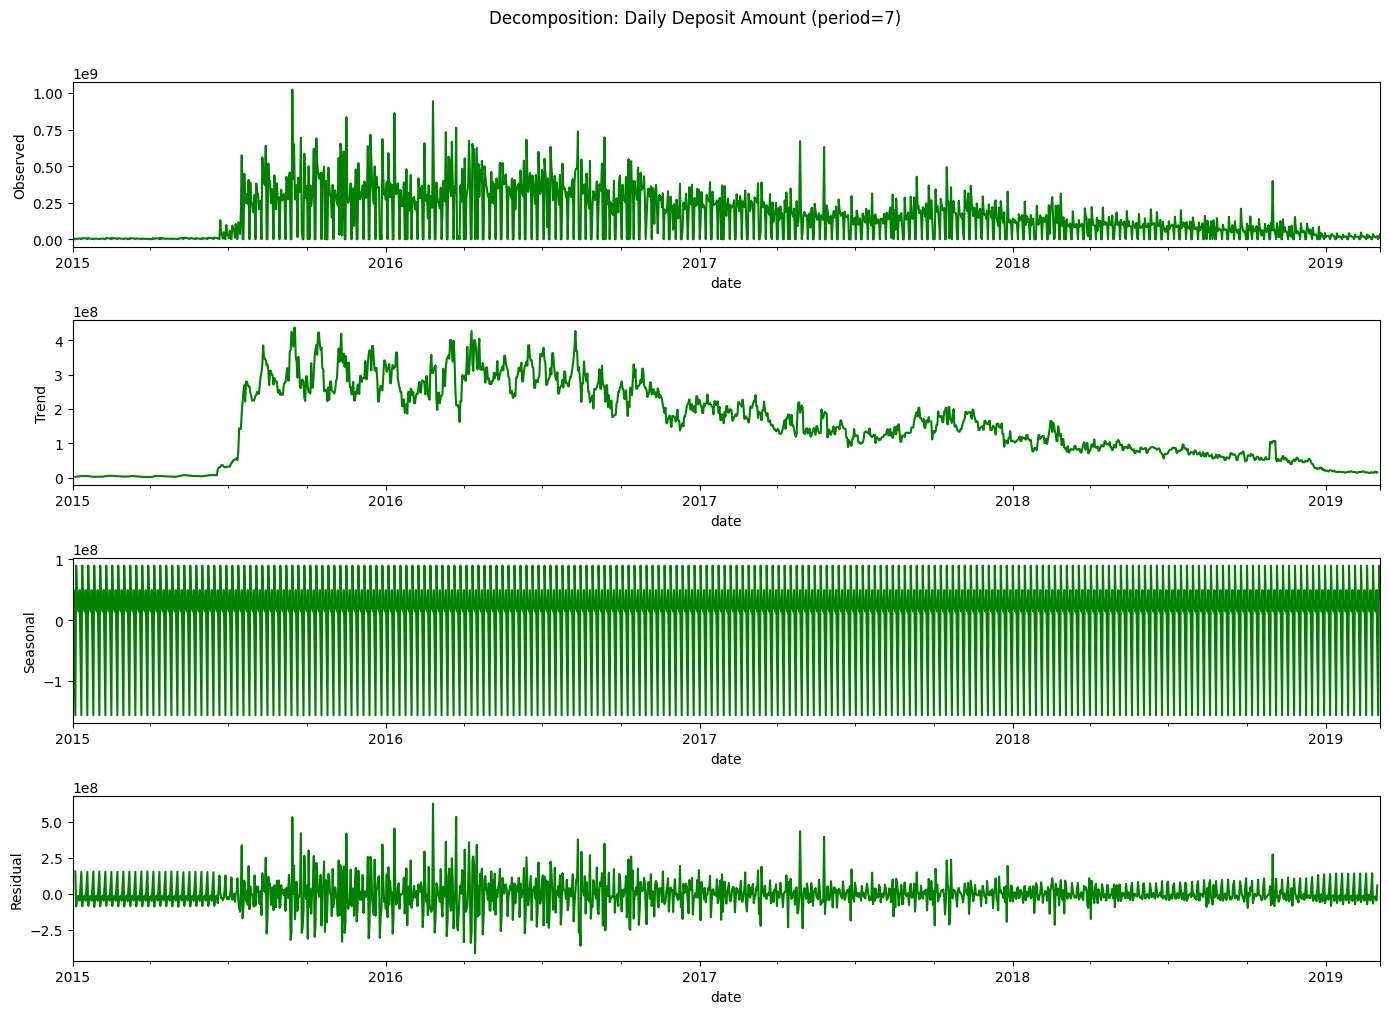

In [16]:
# Decompose DEPOSIT amount
decomp_d = seasonal_decompose(df['deposit_amt'], model='additive', period=7)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
decomp_d.observed.plot(ax=axes[0], color='green')
axes[0].set_ylabel('Observed')
decomp_d.trend.plot(ax=axes[1], color='green')
axes[1].set_ylabel('Trend')
decomp_d.seasonal.plot(ax=axes[2], color='green')
axes[2].set_ylabel('Seasonal')
decomp_d.resid.plot(ax=axes[3], color='green')
axes[3].set_ylabel('Residual')

fig.suptitle('Decomposition: Daily Deposit Amount (period=7)', y=1.01)
plt.tight_layout()
plt.show()

### Step 5: Stationarity Testing (ADF + KPSS)

**Why?** ARIMA requires **stationary** data — constant mean and variance over time.
If data has a trend (mean changes), ARIMA will learn the wrong patterns.

We run TWO tests because they check opposite things:
- **ADF:** "Is it non-stationary?" → low p-value means it IS stationary
- **KPSS:** "Is it stationary?" → low p-value means it is NOT stationary

If both agree → we're confident about the result.

*(See naive_approach.txt → Step 5 for the full decision table)*

In [17]:
from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(series, name):
    print(f'===== {name} =====')
    
    # ADF Test
    adf_result = adfuller(series.dropna())
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'ADF p-value:   {adf_result[1]:.4f}')
    if adf_result[1] < 0.05:
        print('ADF says: STATIONARY (reject non-stationary null)')
    else:
        print('ADF says: NON-STATIONARY (cannot reject null)')
    
    # KPSS Test
    kpss_result = kpss(series.dropna(), regression='ct')
    print(f'\nKPSS Statistic: {kpss_result[0]:.4f}')
    print(f'KPSS p-value:   {kpss_result[1]:.4f}')
    if kpss_result[1] < 0.05:
        print('KPSS says: NON-STATIONARY (reject stationary null)')
    else:
        print('KPSS says: STATIONARY (cannot reject null)')
    print()

check_stationarity(df['withdrawal_amt'], 'Withdrawal Amount (raw)')
check_stationarity(df['deposit_amt'], 'Deposit Amount (raw)')

===== Withdrawal Amount (raw) =====
ADF Statistic: -1.5468
ADF p-value:   0.5103
ADF says: NON-STATIONARY (cannot reject null)

KPSS Statistic: 0.9483
KPSS p-value:   0.0100
KPSS says: NON-STATIONARY (reject stationary null)

===== Deposit Amount (raw) =====
ADF Statistic: -1.6585
ADF p-value:   0.4526
ADF says: NON-STATIONARY (cannot reject null)

KPSS Statistic: 0.9254
KPSS p-value:   0.0100
KPSS says: NON-STATIONARY (reject stationary null)



/var/folders/x7/zt7h82l13lv_5vmk0spybn2m0000gn/T/ipykernel_6635/3340891739.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='ct')
/var/folders/x7/zt7h82l13lv_5vmk0spybn2m0000gn/T/ipykernel_6635/3340891739.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='ct')


### Step 6: Make Data Stationary — Differencing

**Why?** If Step 5 says non-stationary, we fix it by computing **changes** instead of raw values:

```
Raw:        [100, 103, 107, 112, 110]
Differenced: [  3,   4,   5,  -2]      ← Y(t) - Y(t-1)
```

A trend of "going up by ~4/day" becomes a flat line at ~4 after differencing. That's stationary!

The number of times we difference = `d` in ARIMA(p, **d**, q).

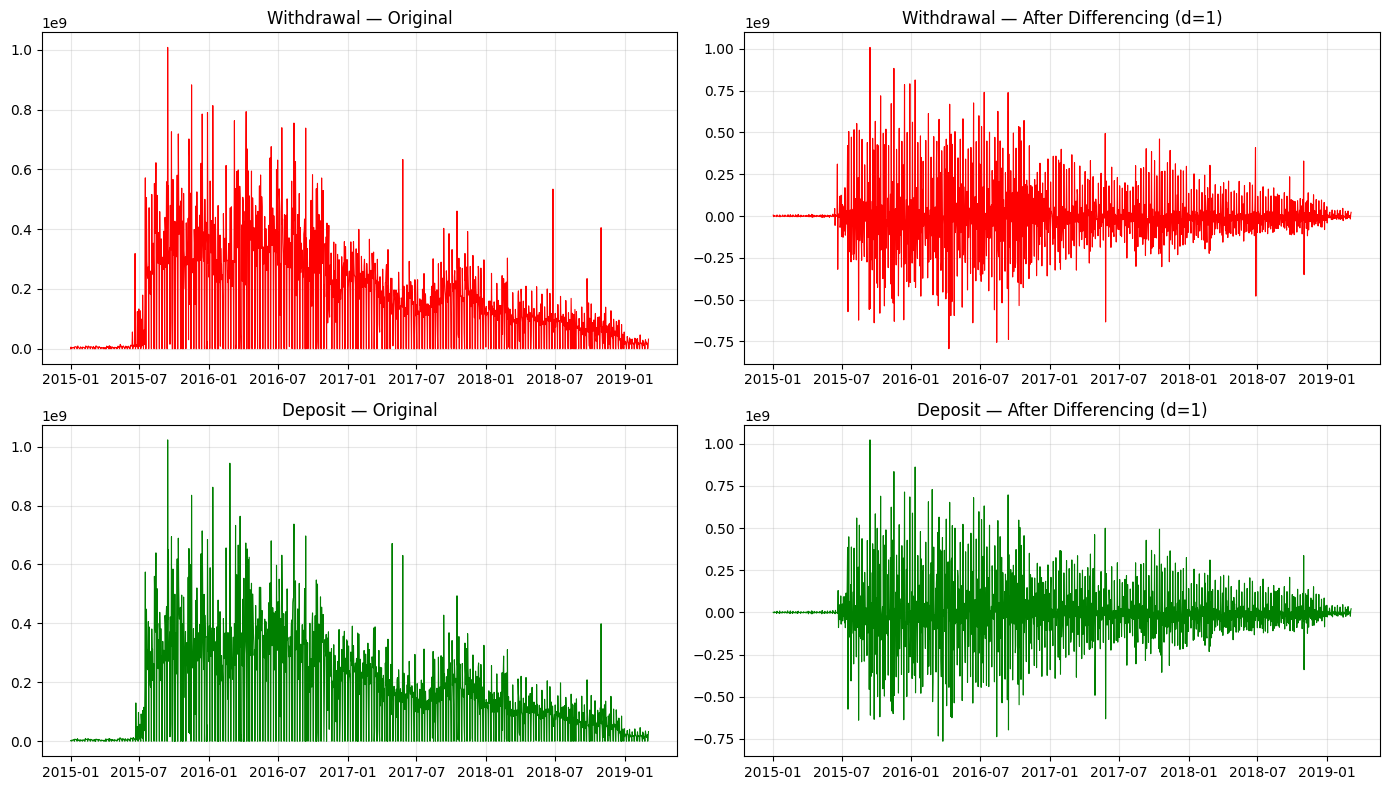

In [18]:
# First-order differencing
withdrawal_diff = df['withdrawal_amt'].diff().dropna()
deposit_diff = df['deposit_amt'].diff().dropna()

# Visual comparison: before vs after
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(df['withdrawal_amt'], color='red', linewidth=0.8)
axes[0, 0].set_title('Withdrawal — Original')

axes[0, 1].plot(withdrawal_diff, color='red', linewidth=0.8)
axes[0, 1].set_title('Withdrawal — After Differencing (d=1)')

axes[1, 0].plot(df['deposit_amt'], color='green', linewidth=0.8)
axes[1, 0].set_title('Deposit — Original')

axes[1, 1].plot(deposit_diff, color='green', linewidth=0.8)
axes[1, 1].set_title('Deposit — After Differencing (d=1)')

for ax in axes.flat:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Re-test: is it stationary NOW?
print('After 1st-order differencing:')
print()
check_stationarity(withdrawal_diff, 'Withdrawal (differenced)')
check_stationarity(deposit_diff, 'Deposit (differenced)')

After 1st-order differencing:

===== Withdrawal (differenced) =====
ADF Statistic: -14.1188
ADF p-value:   0.0000
ADF says: STATIONARY (reject non-stationary null)

KPSS Statistic: 0.0263
KPSS p-value:   0.1000
KPSS says: STATIONARY (cannot reject null)

===== Deposit (differenced) =====
ADF Statistic: -13.6299
ADF p-value:   0.0000
ADF says: STATIONARY (reject non-stationary null)

KPSS Statistic: 0.0339
KPSS p-value:   0.1000
KPSS says: STATIONARY (cannot reject null)



/var/folders/x7/zt7h82l13lv_5vmk0spybn2m0000gn/T/ipykernel_6635/3340891739.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='ct')
/var/folders/x7/zt7h82l13lv_5vmk0spybn2m0000gn/T/ipykernel_6635/3340891739.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='ct')


### Step 7: ACF & PACF Plots — Finding p and q for ARIMA

**Why?** ARIMA(p, d, q) needs 3 numbers. We got `d` from differencing. Now we need:
- `p` (AR order) → read from **PACF** (where bars cut off to zero)
- `q` (MA order) → read from **ACF** (where bars cut off to zero)

Bars outside the blue shaded region = significant autocorrelation at that lag.

*(See naive_approach.txt → Step 7 for how to read these plots)*

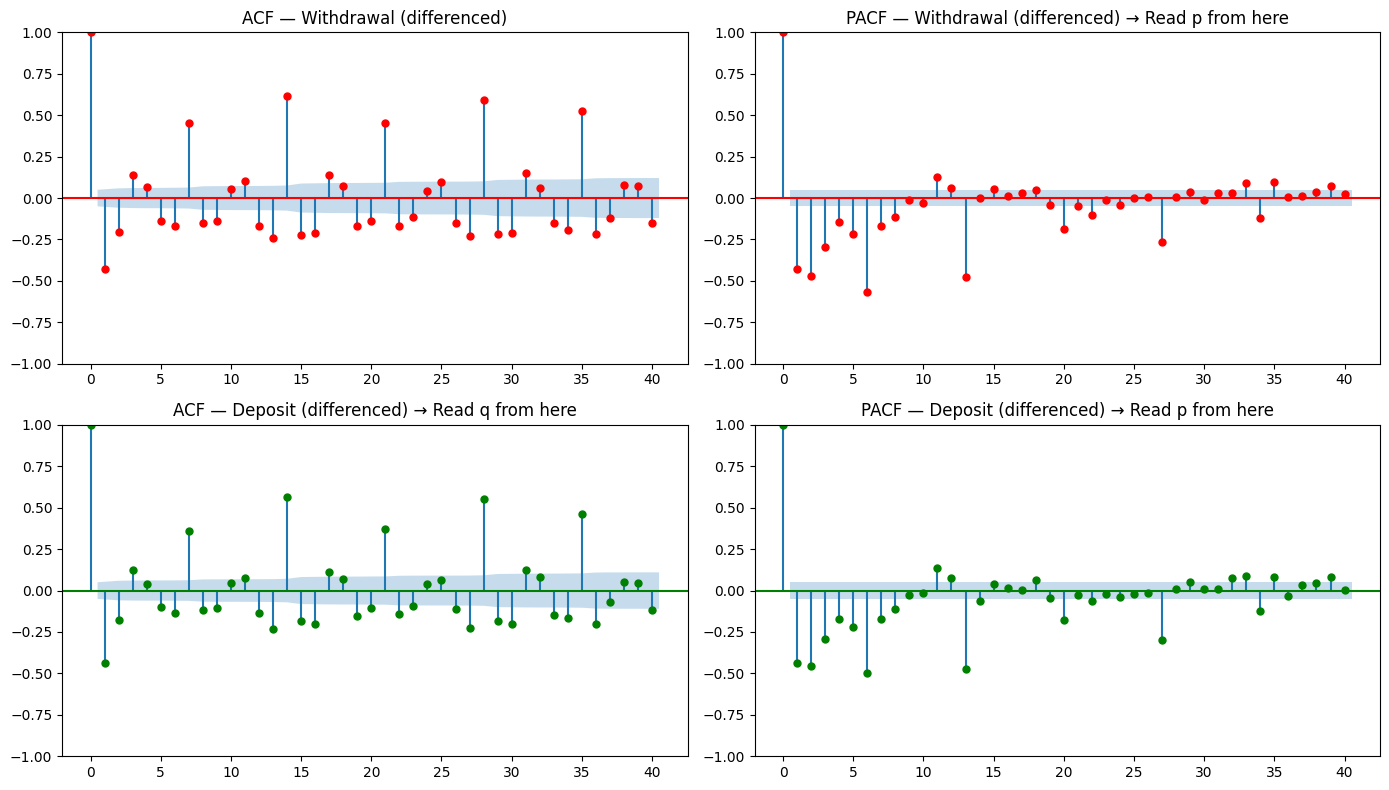

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Withdrawal
plot_acf(withdrawal_diff, ax=axes[0, 0], lags=40, color='red')
axes[0, 0].set_title('ACF — Withdrawal (differenced)')

plot_pacf(withdrawal_diff, ax=axes[0, 1], lags=40, method='ywm', color='red')
axes[0, 1].set_title('PACF — Withdrawal (differenced) → Read p from here')

# Deposit
plot_acf(deposit_diff, ax=axes[1, 0], lags=40, color='green')
axes[1, 0].set_title('ACF — Deposit (differenced) → Read q from here')

plot_pacf(deposit_diff, ax=axes[1, 1], lags=40, method='ywm', color='green')
axes[1, 1].set_title('PACF — Deposit (differenced) → Read p from here')

plt.tight_layout()
plt.show()

### Step 8: Smoothing — SMA & EMA

**Why?** Smoothing removes daily noise to reveal the underlying trend.
- **SMA** (Simple Moving Average): equal weight to all days in window
- **EMA** (Exponential Moving Average): more weight to recent days

These also serve as simple forecast benchmarks.

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Withdrawal smoothing
axes[0].plot(df['withdrawal_amt'], color='lightcoral', linewidth=0.5, label='Raw')
axes[0].plot(df['withdrawal_amt'].rolling(7).mean(), color='darkred', linewidth=1.5, label='SMA-7')
axes[0].plot(df['withdrawal_amt'].ewm(span=7).mean(), color='orange', linewidth=1.5, label='EMA-7')
axes[0].set_title('Withdrawal Amount — Smoothed')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Deposit smoothing
axes[1].plot(df['deposit_amt'], color='lightgreen', linewidth=0.5, label='Raw')
axes[1].plot(df['deposit_amt'].rolling(7).mean(), color='darkgreen', linewidth=1.5, label='SMA-7')
axes[1].plot(df['deposit_amt'].ewm(span=7).mean(), color='olive', linewidth=1.5, label='EMA-7')
axes[1].set_title('Deposit Amount — Smoothed')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part C: Modeling

Now we build models, simplest to most complex:
1. **Naive Forecast** (baseline) — "tomorrow = today"
2. **Simple Exponential Smoothing** — weighted average of past
3. **Holt-Winters** — handles trend + seasonality
4. **ARIMA** — the classic workhorse
5. **SARIMA** — ARIMA + seasonal component

All evaluated on the same test set with the same metrics.

### Step 9: Train / Test Split

**Why time-based, NOT random?** In time series, using future data to predict the past
is cheating (data leakage). The split MUST respect time order:

```
Train: [2015-01-01 ──────────────────────── ] (all except last 30 days)
Test:  [                          last 30 days] (predict these)
```

In [ ]:
test_size = 30  # last 30 days

train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

print(f'Train: {train.index.min()} to {train.index.max()} ({len(train)} days)')
print(f'Test:  {test.index.min()} to {test.index.max()} ({len(test)} days)')

# Visualize the split
plt.figure(figsize=(14, 4))
plt.plot(train.index, train['withdrawal_amt'], color='blue', label='Train')
plt.plot(test.index, test['withdrawal_amt'], color='red', label='Test')
plt.title('Train / Test Split — Withdrawal Amount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Evaluation Metrics Setup

We'll compare all models using these metrics:
- **MAE** — average absolute error (in rupees)
- **RMSE** — penalizes big errors more
- **MAPE** — error as percentage (easiest to explain)

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(actual, predicted, model_name):
    """Calculate and print MAE, RMSE, MAPE for a model."""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    # MAPE: avoid division by zero
    nonzero = actual != 0
    if nonzero.sum() > 0:
        mape = np.mean(np.abs((actual[nonzero] - predicted[nonzero]) / actual[nonzero])) * 100
    else:
        mape = np.nan
    
    print(f'{model_name:30s} | MAE: {mae:>15,.0f} | RMSE: {rmse:>15,.0f} | MAPE: {mape:>6.1f}%')
    return {'model': model_name, 'mae': mae, 'rmse': rmse, 'mape': mape}

# Store results for final comparison
results = []

### Step 10: Model 1 — Naive Forecast (Baseline)

**What:** "Tomorrow's withdrawal = today's withdrawal." The simplest possible prediction.

**Why start here?** This is our baseline. If a complex model can't beat "same as yesterday,"
then the complex model is useless. Every model must beat this to be worth using.

In [ ]:
# Naive: prediction = previous day's value
naive_pred_w = test['withdrawal_amt'].shift(1).bfill()  # first day has no "yesterday" in test, use backfill
naive_pred_d = test['deposit_amt'].shift(1).bfill()

print('--- WITHDRAWAL ---')
results.append(evaluate(test['withdrawal_amt'].values, naive_pred_w.values, 'Naive (Withdrawal)'))
print('--- DEPOSIT ---')
results.append(evaluate(test['deposit_amt'].values, naive_pred_d.values, 'Naive (Deposit)'))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(test.index, test['withdrawal_amt'], label='Actual', color='blue')
axes[0].plot(test.index, naive_pred_w, label='Naive', color='red', linestyle='--')
axes[0].set_title('Naive Forecast — Withdrawal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(test.index, test['deposit_amt'], label='Actual', color='blue')
axes[1].plot(test.index, naive_pred_d, label='Naive', color='red', linestyle='--')
axes[1].set_title('Naive Forecast — Deposit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 11: Model 2 — Simple Exponential Smoothing (SES)

**What:** Weighted average of ALL past values, where recent values get MORE weight.
The weight decays exponentially — yesterday matters a lot, last month barely matters.

**When to use:** When there's NO trend and NO seasonality — just noisy data around a level.

**How it improves on Naive:** Naive uses only 1 past value. SES uses ALL past values
(weighted), so it's less jerky and more stable.

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# SES for Withdrawal
ses_model_w = SimpleExpSmoothing(train['withdrawal_amt']).fit()
ses_pred_w = ses_model_w.forecast(test_size)

# SES for Deposit
ses_model_d = SimpleExpSmoothing(train['deposit_amt']).fit()
ses_pred_d = ses_model_d.forecast(test_size)

print('--- WITHDRAWAL ---')
results.append(evaluate(test['withdrawal_amt'].values, ses_pred_w.values, 'SES (Withdrawal)'))
print('--- DEPOSIT ---')
results.append(evaluate(test['deposit_amt'].values, ses_pred_d.values, 'SES (Deposit)'))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(test.index, test['withdrawal_amt'], label='Actual', color='blue')
axes[0].plot(test.index, ses_pred_w.values, label='SES', color='red', linestyle='--')
axes[0].set_title('SES Forecast — Withdrawal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(test.index, test['deposit_amt'], label='Actual', color='blue')
axes[1].plot(test.index, ses_pred_d.values, label='SES', color='red', linestyle='--')
axes[1].set_title('SES Forecast — Deposit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 12: Model 3 — Holt-Winters (Triple Exponential Smoothing)

**What:** Handles TREND + SEASONALITY. Three components:
- Level (like SES)
- Trend (going up or down)
- Seasonality (repeating pattern every `seasonal_periods` days)

**Why over SES?** If the decomposition in Step 4 showed trend and/or seasonality,
SES can't capture those. Holt-Winters can.

We use `seasonal_periods=7` for weekly pattern.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Holt-Winters for Withdrawal
hw_model_w = ExponentialSmoothing(
    train['withdrawal_amt'],
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()
hw_pred_w = hw_model_w.forecast(test_size)

# Holt-Winters for Deposit
hw_model_d = ExponentialSmoothing(
    train['deposit_amt'],
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()
hw_pred_d = hw_model_d.forecast(test_size)

print('--- WITHDRAWAL ---')
results.append(evaluate(test['withdrawal_amt'].values, hw_pred_w.values, 'Holt-Winters (Withdrawal)'))
print('--- DEPOSIT ---')
results.append(evaluate(test['deposit_amt'].values, hw_pred_d.values, 'Holt-Winters (Deposit)'))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(test.index, test['withdrawal_amt'], label='Actual', color='blue')
axes[0].plot(test.index, hw_pred_w.values, label='Holt-Winters', color='red', linestyle='--')
axes[0].set_title('Holt-Winters Forecast — Withdrawal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(test.index, test['deposit_amt'], label='Actual', color='blue')
axes[1].plot(test.index, hw_pred_d.values, label='Holt-Winters', color='red', linestyle='--')
axes[1].set_title('Holt-Winters Forecast — Deposit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 13: Model 4 — ARIMA

**What:** The classic time series model. Combines:
- **AR** (Auto-Regressive): past VALUES predict future
- **I** (Integrated): differencing to make stationary
- **MA** (Moving Average): past ERRORS predict future

**ARIMA(p, d, q):**
- `p` → from PACF plot (Step 7)
- `d` → from differencing (Step 6)
- `q` → from ACF plot (Step 7)

We start with a reasonable ARIMA(7, 1, 7) — captures weekly lag patterns.
You can adjust p and q based on what you observed in the ACF/PACF plots.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA for Withdrawal
arima_model_w = ARIMA(train['withdrawal_amt'], order=(7, 1, 7))
arima_fit_w = arima_model_w.fit()
arima_pred_w = arima_fit_w.forecast(test_size)

# ARIMA for Deposit
arima_model_d = ARIMA(train['deposit_amt'], order=(7, 1, 7))
arima_fit_d = arima_model_d.fit()
arima_pred_d = arima_fit_d.forecast(test_size)

print('--- WITHDRAWAL ---')
results.append(evaluate(test['withdrawal_amt'].values, arima_pred_w.values, 'ARIMA(7,1,7) (Withdrawal)'))
print('--- DEPOSIT ---')
results.append(evaluate(test['deposit_amt'].values, arima_pred_d.values, 'ARIMA(7,1,7) (Deposit)'))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(test.index, test['withdrawal_amt'], label='Actual', color='blue')
axes[0].plot(test.index, arima_pred_w.values, label='ARIMA', color='red', linestyle='--')
axes[0].set_title('ARIMA Forecast — Withdrawal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(test.index, test['deposit_amt'], label='Actual', color='blue')
axes[1].plot(test.index, arima_pred_d.values, label='ARIMA', color='red', linestyle='--')
axes[1].set_title('ARIMA Forecast — Deposit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 14: Model 5 — SARIMA (Seasonal ARIMA)

**What:** ARIMA ignores seasonality. If withdrawals spike every Monday or every month-end,
plain ARIMA won't capture that. SARIMA adds a seasonal layer.

**SARIMA(p, d, q)(P, D, Q, s):**
- `(p, d, q)` = same as ARIMA (non-seasonal)
- `(P, D, Q, s)` = seasonal part:
  - P = seasonal AR terms
  - D = seasonal differencing (usually 1)
  - Q = seasonal MA terms
  - s = season length (7 for weekly)

We use (1,1,1,7) for the seasonal part — simple weekly seasonality.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA for Withdrawal
sarima_model_w = SARIMAX(
    train['withdrawal_amt'],
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 7)
)
sarima_fit_w = sarima_model_w.fit(disp=False)
sarima_pred_w = sarima_fit_w.forecast(test_size)

# SARIMA for Deposit
sarima_model_d = SARIMAX(
    train['deposit_amt'],
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 7)
)
sarima_fit_d = sarima_model_d.fit(disp=False)
sarima_pred_d = sarima_fit_d.forecast(test_size)

print('--- WITHDRAWAL ---')
results.append(evaluate(test['withdrawal_amt'].values, sarima_pred_w.values, 'SARIMA (Withdrawal)'))
print('--- DEPOSIT ---')
results.append(evaluate(test['deposit_amt'].values, sarima_pred_d.values, 'SARIMA (Deposit)'))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(test.index, test['withdrawal_amt'], label='Actual', color='blue')
axes[0].plot(test.index, sarima_pred_w.values, label='SARIMA', color='red', linestyle='--')
axes[0].set_title('SARIMA Forecast — Withdrawal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(test.index, test['deposit_amt'], label='Actual', color='blue')
axes[1].plot(test.index, sarima_pred_d.values, label='SARIMA', color='red', linestyle='--')
axes[1].set_title('SARIMA Forecast — Deposit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part D: Model Comparison

### Step 15: Final Comparison Table

All models, same test set, same metrics. The model with the lowest RMSE/MAPE wins.

In [ ]:
comparison = pd.DataFrame(results)
comparison = comparison.round(2)

print('=' * 85)
print('MODEL COMPARISON — ALL MODELS ON SAME TEST SET (Last 30 Days)')
print('=' * 85)
print()

# Withdrawal models
print('WITHDRAWAL AMOUNT:')
w_models = comparison[comparison['model'].str.contains('Withdrawal')].sort_values('rmse')
print(w_models.to_string(index=False))
print(f'\nBest model: {w_models.iloc[0]["model"]}')

print()

# Deposit models
print('DEPOSIT AMOUNT:')
d_models = comparison[comparison['model'].str.contains('Deposit')].sort_values('rmse')
print(d_models.to_string(index=False))
print(f'\nBest model: {d_models.iloc[0]["model"]}')

In [ ]:
# Visual comparison — RMSE bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

w_models_sorted = w_models.sort_values('rmse', ascending=True)
axes[0].barh(w_models_sorted['model'].str.replace(' \(Withdrawal\)', '', regex=True),
             w_models_sorted['rmse'], color='salmon')
axes[0].set_xlabel('RMSE (lower is better)')
axes[0].set_title('Withdrawal — Model Comparison')

d_models_sorted = d_models.sort_values('rmse', ascending=True)
axes[1].barh(d_models_sorted['model'].str.replace(' \(Deposit\)', '', regex=True),
             d_models_sorted['rmse'], color='lightgreen')
axes[1].set_xlabel('RMSE (lower is better)')
axes[1].set_title('Deposit — Model Comparison')

plt.tight_layout()
plt.show()

---
## Summary: What We Did & What We Learned

| Step | What | Why |
|------|------|-----|
| Date as index | `set_index('value_date')` | Time series tools need datetime index |
| Fill gaps | Reindex to continuous calendar | Models need every day, no skips |
| Visualize | Line plots | Spot trends, seasonality, outliers by eye |
| Decompose | Trend + Seasonal + Residual | Understand what's driving the data |
| Stationarity | ADF + KPSS tests | Check if differencing is needed |
| Differencing | Y(t) - Y(t-1) | Make data stationary for ARIMA |
| ACF/PACF | Autocorrelation plots | Pick p and q for ARIMA |
| Smoothing | SMA, EMA | See underlying trend through noise |
| Naive baseline | Tomorrow = today | Minimum bar every model must beat |
| SES | Weighted average of past | Simple, no trend/seasonality |
| Holt-Winters | Level + trend + seasonality | Captures weekly patterns |
| ARIMA | AR + differencing + MA | Classic workhorse |
| SARIMA | ARIMA + seasonal layer | Best for data with weekly/monthly cycles |
| Comparison | Same test set, same metrics | Fair apples-to-apples ranking |

**Next steps:** Use the best model to generate 7-day and 30-day ahead forecasts with confidence intervals.